In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2025 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Rafael Flock (DTU)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Certified coordinate selection for high-dimensional Bayesian inversion with Laplace prior

### Rafael Flock (raff@dtu.dk)

**Notice** You need CUQIpy-PyTorch to run this notebook.

This notebook demonstrates the use of the certified coordinate selection (CCS) method proposed in https://doi.org/10.1007/s11222-024-10445-1. CCS considers high-dimensional Bayesian inverse problems with product-form Laplace priors. The method proposes an approximate posterior by applying a gradient-based diagnostic to identify coordinates that contribute most to the update from the prior to the posterior. Afterwards, the approximate posterior can be efficiently inferred with Markov chain Monte Carlo (MCMC) methods since most of its coordinates are only informed by the prior.


We start by importing the necessary libraries.

In [2]:
# modules
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pywt
import cvxpy as cp
import matplotlib.pyplot as plt
from pathlib import PurePath, Path
from scipy.stats import laplace
import pickle
import os
from time import time

import cuqi
import torch
from cuqi.distribution import JointDistribution
from cuqipy_pytorch.distribution import Gaussian
from cuqipy_pytorch.sampler import NUTS

from utils import *

For the convenience of configuration, we collect all parameters to be used here.

In [3]:
## parameters
# ground truth file
true_signal_file = PurePath(r'oneD_pw_const_1022.npy')

# noise (additive Gaussian)
noise_seed = 0
noise_std = 3e-2

# blurring
blur_r = 12 # radius
blur_std = 6
blur_BC = 'reflect' # (d c b a | a b c d | d c b a)

# wavelet
wavelet = 'haar'
wavelet_BC = 'symmetric' # as blur_BC (half-sample symmetric)

# sampling
n_I = 50 # number of selected coordinates
beta = 1e-5 # smoothing parameter for Laplace gradient
N_po = 10_000 # posterior samples
N_b = 1_000 # burn in
CI = 95 # credibility interval to show in percent


The problem under consdieration is the following:
$$y = Gs + e,$$
where $G$ is the convolution operator with a Gaussian kernel and $s$ is the signal to recover and $e$ is Gaussian noise due to measurement. We further apply the wavelet transform W to transform the signal to the domain of wavelet coefficients, i.e., $s=Wx$. Particularly, we choose a 10-level Haar wavelets with perodic boundary conditions, and the dimension of $x$ is 60. With such a wavelet transform, we can rewrite the problem in the following equavilent form:
$$y = GWx + e.$$
For brevity, we denote $A\equiv GW$ and in the following compute it a matrix form.

In [4]:
## model matrix
# blur
G = lambda x: gaussian_filter1d(input=x, sigma=blur_std, mode=blur_BC, radius=blur_r)

# wavelet synthesis operator
s_true = np.load(Path(true_signal_file))
coeffs = pywt.wavedec(s_true, wavelet, wavelet_BC)   
x_true, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
d = x_true.size
W = lambda x: pywt.waverec(pywt.unravel_coeffs(x, coeff_slices, coeff_shapes, 'wavedec'), wavelet, wavelet_BC)
print(f'check synthesis: {np.max(np.abs(s_true-W(x_true)))}')

# construct matrix
A_op = lambda x: G( W(x) )
A = np.zeros((A_op(x_true).size, d), dtype=np.double)
for ii in range(d):
    e = np.insert( np.zeros(d-1), ii, 1) 
    A[:, ii] = A_op(e)

check synthesis: 1.7763568394002505e-15


Now we describe the preparation of the synthetic data. We first import the ground truth signal `x_true` from an external .npy file and apply the convolution $G$ operation on it to obtain `y_true`. Afterwards, a Gaussian noise is added to `y_true`.

In [5]:
# true and noisy signal
s_true = np.load(Path(true_signal_file))
y_true = G(s_true)
np.random.default_rng(seed=noise_seed)
y = y_true + np.random.normal(scale=noise_std, size=y_true.size)
noise_level = noise_std / np.linalg.norm(y_true) * np.sqrt( y_true.size )
lam = 1/noise_std**2 # precision of noise

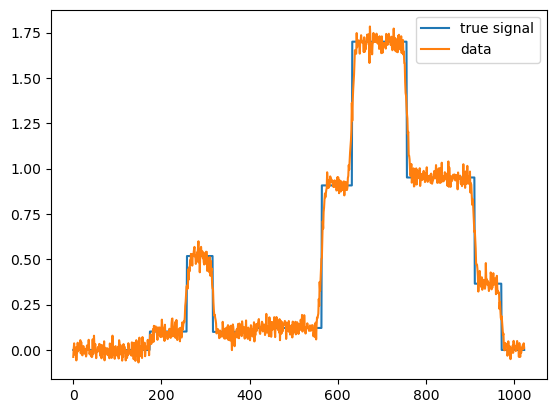

In [6]:
# plot signal and data
plt.figure()
plt.plot(s_true, label='true signal')
plt.plot(y, label='data')
plt.legend()
plt.show()

We note that we intend to use an anisotropic Laplace prior for the wavelet coefficients $x$ whose weights are predetermined as in a Besov prior. Here we compute the weights and save them in `delta`.

In [9]:
# rate parameters according to Besov^1_11 prior
delta_f = lambda l: 2**(1/2*l) # 2^(j* (s+d/2-d/p) ) where: j level (approx level scaled by 1),  d (dimension) = 1, p=s=1 
delta = np.zeros(d, dtype=np.double)
delta[coeff_slices[0]] = delta_f(0)
for ii in range(1, len(coeff_slices)):
    delta[coeff_slices[ii]['d']] = delta_f(ii)

Accordingly we define the prior distribution as a Laplace in a product form with the rate parameters computed from `delta``.

In [10]:
# prior mean and covariance
pr_mean = np.zeros(d)
pr_cov = np.diag(2/delta**2)

Here we compute the MAP estimate of the solution using the cvxpy package. We also approximate the Hessian at MAP point.

In [ ]:
## mean and covariance of Gaussian approximation at MAP ('Laplace approximation')

# find MAP
x = cp.Variable(d)
objective = cp.Minimize(lam/2* cp.sum_squares(y - A @ x) + cp.pnorm(cp.multiply(delta, x), 1))
problem = cp.Problem(objective)
result = problem.solve(verbose=1, max_iter=20000)
MAP_mean = x.value

# mean and covariance
eps_Hess = 4/np.max(delta)**2 # smoothing parameter (computed based on heuristic rule) for approximation of covariance
Hess = lam * A.T @ A + np.diag( delta*eps_Hess * 1/np.sqrt(MAP_mean**2 + eps_Hess)**3  ) # -\nabla^2\log\pi(x_MAP)
U, S, _ = np.linalg.svd(Hess, hermitian=1)
print(f'max abs error SVD: {np.max( np.abs( U@np.diag(S)@U.T - Hess ))}')
MAP_cov =  U@np.diag(1/S)@U.T

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Nov 19 06:13:04 PM: Your problem has 1024 variables, 0 constraints, and 0 parameters.
(CVXPY) Nov 19 06:13:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 19 06:13:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 19 06:13:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 19 06:13:04 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 19 06:13:04 PM: Compiling problem (target solver=OSQP).
(C

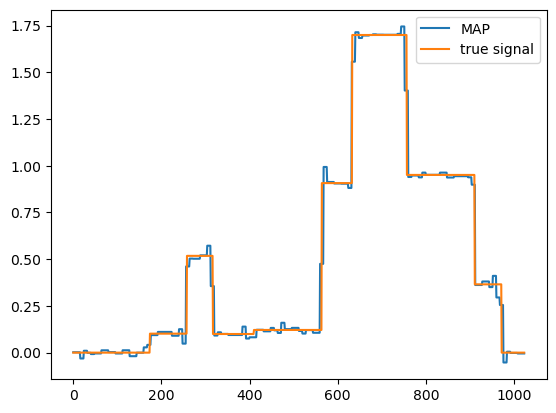

In [12]:
# plot MAP in signal space
plt.figure()
plt.plot(W(MAP_mean), label='MAP')
plt.plot(s_true, label='true signal')
plt.legend()

The diagostic can be either estimated from the prior, the MAP point or the posterior. We note the `diagnostic` function implements Eq. 16 of the reference paper. Here we are ready to estimate the diagostic with the above computed information on the MAP and the posterior.

In [13]:
## diagnostic given estimates of posterior mean and covariance (-> CUQIpy?)

def diagnostic(A, y, rates, noise_prec, po_mean, po_cov):
    H = A.T@noise_prec@A
    d1 = np.sum( (H@po_cov).T * H, axis=0 ) # diagonal of H@po_cov@H    
    d2 = (A.T@(noise_prec@(y-A@po_mean)))**2
    return 1/rates**2 * (d1+d2) # = h

# estimate via prior
d_prior = diagnostic(A, y, delta, lam*np.eye(y.size), pr_mean, pr_cov)

# estimate via MAP
d_MAP = diagnostic(A, y, delta, lam*np.eye(y.size), MAP_mean, MAP_cov)

To compute the dianostic on the posterior, we need to sample from the posterior. Here we use the NUTS sampler from CUQIpy-PyTorch.

In [14]:
## prepare sampling of full posterior for reference samples

# scaling factor
s = delta

# prior
X = LaplaceSmoothed(location=torch.zeros(d, dtype=torch.double), scale=torch.from_numpy(1/s*1/delta), beta=beta)

# likelihood
A_torch = torch.from_numpy(A@np.diag(s))
noise_cov = (noise_std**2*torch.ones(A_torch.shape[0])).double()
Y = Gaussian(lambda X: torch.matmul(A_torch, X.double()), cov=noise_cov)

# posterior
X_Y = JointDistribution(X, Y)
p = X_Y(Y=y)

# sampler
torch.manual_seed(0)
nuts_sampler_ref = NUTS(p)

In [15]:
# # sample full posterior
# samples_ref0 = nuts_sampler_ref.sample(N_po, N_b)
# # Sample: 100%|██████████| 11000/11000 [05:06, 35.92it/s, step size=1.46e-01, acc. prob=0.842]

# # save samples
# save(PurePath(os.getcwd(), 'ref_samples'), samples_ref0)

# load samples
samples_ref0 = load(PurePath(os.getcwd(), 'ref_samples'))

Selecting 5 randomly chosen variables


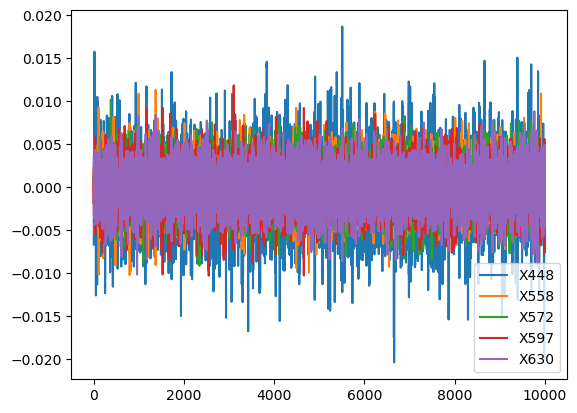

In [16]:
# check some traces
samples_ref0['X'].plot_chain()

In [17]:
# rescale and transform to signal space
np_samples_ref = np.diag(s) @ samples_ref0['X'].samples 
samples_ref = cuqi.samples.Samples(np_samples_ref)
samples_ref_signal = cuqi.samples.Samples(np.apply_along_axis(func1d=W, arr=np_samples_ref, axis=0))

Why the following is computed differently from the prior and the MAP?

I have a feeling that this notebook contains a lot information and a reader might get lost. Could we remove the part on comparing different diagostics and focus on only the comparsion of the approximate the full posteriors?

In [18]:
# # compute reference diagnostic
# log_like = lambda x: -lam * A.T@(y-A@x)
# d_ref = np.apply_along_axis(func1d=log_like, arr=np_samples_ref, axis=0)
# d_ref = 1/delta**2 * np.mean(d_ref**2, axis=1)
# save(PurePath(os.getcwd(), 'ref_diagnostic'), d_ref)

# load
d_ref = load(PurePath(os.getcwd(), 'ref_diagnostic'))

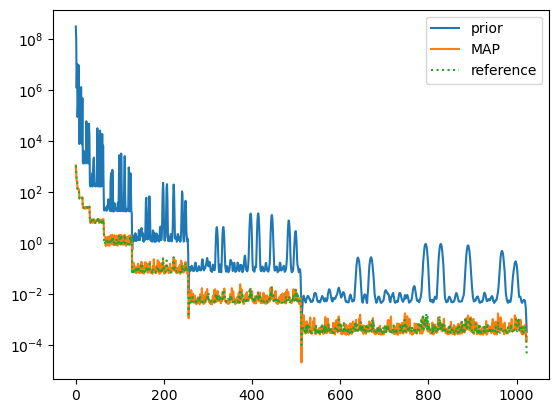

In [19]:
# plot diagnostics
plt.figure()
plt.semilogy(d_prior, label='prior')
plt.semilogy(d_MAP, label='MAP')
plt.semilogy(d_ref, label='reference', ls=':')
# plt.ylim([1e-4,1e10])
plt.legend()

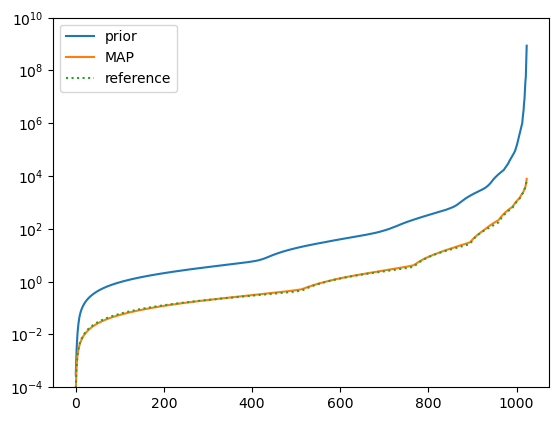

In [20]:
# plot upper bounds on Hellinger squared between exact and approx posterior
plt.figure()
plt.semilogy(2*np.cumsum(np.sort(d_prior)), label='prior')
plt.semilogy(2*np.cumsum(np.sort(d_MAP)), label='MAP')
plt.semilogy(2*np.cumsum(np.sort(d_ref)), label='reference', ls=':')
plt.ylim([1e-4,1e10])
plt.legend()

In [21]:
## reference posterior statistics

# mean
x_mean_ref = samples_ref.mean()
x_mean_ref_signal = samples_ref_signal.mean()

# CI
x_l_ref = samples_ref.compute_ci(CI)[0,:]
x_u_ref = samples_ref.compute_ci(CI)[1,:]
x_l_ref_signal = samples_ref_signal.compute_ci(CI)[0,:]
x_u_ref_signal = samples_ref_signal.compute_ci(CI)[1,:]

In [22]:
## prepare sampling of reduced posterior

# select coordinates via diagnostic obtained from prior 
I = np.argsort(d_prior)[-n_I:]
I_c = np.setdiff1d(np.arange(d), I)

# scaling factor
s = delta[I]

# prior
X = LaplaceSmoothed(location=torch.zeros(n_I, dtype=torch.double), scale=torch.from_numpy(1/s*1/delta[I]), beta=beta)

# likelihood
A_red = A[:,I]@np.diag(s)
A_red_torch = torch.from_numpy(A_red)
noise_cov = (noise_std**2*torch.ones(A_red_torch.shape[0])).double()
Y = Gaussian(lambda X: torch.matmul(A_red_torch, X.double()), cov=noise_cov)

# posterior
X_Y = JointDistribution(X, Y)
p = X_Y(Y=y)

# sampler
torch.manual_seed(1)
nuts_sampler = NUTS(p)

In [23]:
# sample reduced posterior in selected coordinates
# samples0 = nuts_sampler.sample(N_po, N_b)
# Sample: 100%|██████████| 11000/11000 [01:26, 126.91it/s, step size=4.24e-01, acc. prob=0.845]

# save samples
# save(PurePath(os.getcwd(), 'red_samples'), samples0)

# load samples
samples0 = load(PurePath(os.getcwd(), 'red_samples'))

Selecting 5 randomly chosen variables


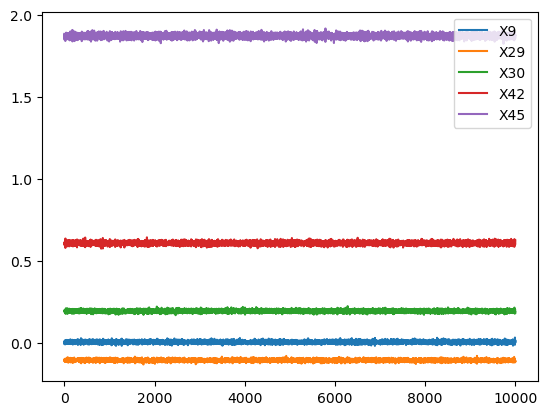

In [24]:
# check some traces
samples0['X'].plot_chain()

In [25]:
# sample not selected coordinates from prior 
np_samples = np.zeros((d, N_po))
np_samples[I_c] = fast_Laplace(delta[I_c], N_po)

# rescale samples from NUTS
np_samples[I] = np.diag(s)@samples0['X'].samples
samples = cuqi.samples.Samples(np_samples)

# transform to signal space
samples_signal = cuqi.samples.Samples(np.apply_along_axis(func1d=W, arr=np_samples, axis=0))

In [26]:
## reduced posterior statistics

# mean
x_mean = samples.mean()
x_mean_signal = samples_signal.mean()

# CI
x_l = samples.compute_ci(CI)[0,:]
x_u = samples.compute_ci(CI)[1,:]
x_l_signal = samples_signal.compute_ci(CI)[0,:]
x_u_signal = samples_signal.compute_ci(CI)[1,:]

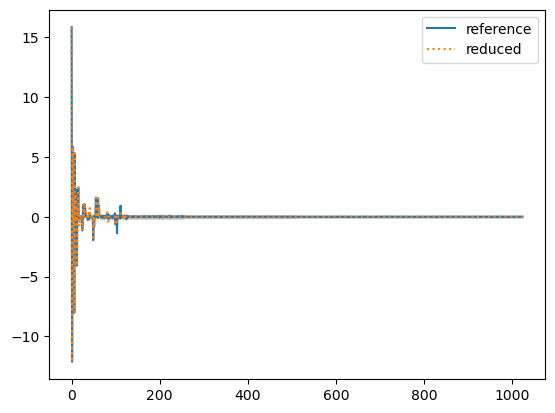

In [27]:
# plot statistics in coefficient space
plt.figure()
p = plt.plot(x_mean_ref, label='reference')
plt.fill_between(np.arange(d), x_u_ref, x_l_ref, color=p[-1].get_color(), alpha=0.3, lw=0)
p = plt.plot(x_mean, label='reduced', ls=':')
plt.fill_between(np.arange(d), x_u, x_l, color=p[-1].get_color(), alpha=0.3, lw=0)
# plt.xlim([0,10])
plt.legend()

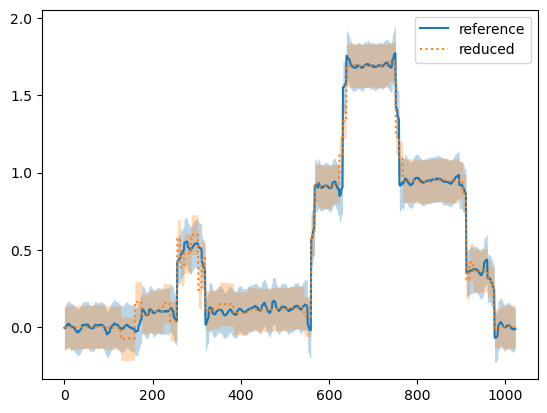

In [28]:
# plot statistics in signal space
plt.figure()
p = plt.plot(x_mean_ref_signal, label='reference')
plt.fill_between(np.arange(d), x_u_ref_signal, x_l_ref_signal, color=p[-1].get_color(), alpha=0.3, lw=0)
p = plt.plot(x_mean_signal, label='reduced', ls=':')
plt.fill_between(np.arange(d), x_u_signal, x_l_signal, color=p[-1].get_color(), alpha=0.3, lw=0)
# plt.xlim([0,10])
plt.legend()